---

## 1. OVERVIEW & METHODOLOGY

### 1.1 Purpose

This notebook performs **data quality control and consolidation** on the feature-extracted tree datasets from three German cities (Berlin, Hamburg, Rostock). The primary goals are:

1.  **Consolidate**: Combine city-specific datasets into unified files (no-edge and 20m-edge variants).
2.  **Species type filter**: Filters out conifer trees.
3.  **Analyze Completeness**: Assess temporal NaN patterns across the 276 Sentinel-2 features.
4.  **Validate Schema**: Ensure all 280+ features and metadata columns are correctly structured.

**Key methodological principles:**
- **No feature reduction**: All  are preserved for subsequent selection.

**Quality control focus:**
- **Data completeness**: Identify systematic temporal gaps.
- **Taxonomic clarity**: Standardize genus-level metadata for stratified analysis.

### 1.2 Workflow

```
[PHASE 1: DATA LOADING & CONSOLIDATION]
├── Step 1.1: Load 6 city-specific datasets (3 cities × 2 variants)
├── Step 1.2: Add variant identifier ('no_edge' vs. 'edge_20m')
├── Step 1.3: Concatenate into two unified datasets
└── Step 1.4: Validation of feature counts (23 bands × 12 months)

↓

[PHASE 2: GENUS ANALYSIS & METADATA ENRICHMENT]
├── Step 2.1: Extract unique genera
├── Step 2.2: Define Genus → Species Group mapping (deciduous/conifer)
└── Step 2.3: Filter out confier trees

↓

[PHASE 3: NaN ANALYSIS (DESCRIPTIVE)]
├── Step 3.1: Calculate per-month NaN percentages
├── Step 3.2: Analyze per-tree missingness
└── Step 3.3: Visualize systematic gaps (Heatmap)

↓

[PHASE 4: FINAL VALIDATION & EXPORT]
├── Step 4.1: Compute final statistics (City, Species Group, Location Type)
├── Step 4.2: Compare edge-filter impact
├── Step 4.3: Validate schema, CRS, and geometry
└── Step 4.4: Export clean GeoPackages and metadata reports

↓

[OUTPUT: Consolidated QC datasets + Metadata]
```

### 1.3 Expected Outputs

| File                                   | Type       | Description                                                                 |
| -------------------------------------- | ---------- | --------------------------------------------------------------------------- |
| `trees_qc_no_edge.gpkg`               | GeoPackage | Unified dataset (all trees), enriched with `species_group`                  |
| `trees_qc_edge_20m.gpkg`              | GeoPackage | Unified dataset (edge filtered), enriched with `species_group`              |
| `genus_type_mapping.json`             | JSON       | Mapping: Genus → Species Group (deciduous/conifer)                          |
| `nan_statistics_by_month_city.csv`    | CSV        | NaN statistics per month and city                                           |
| `qc_report.json`                      | JSON       | Comprehensive processing report (counts, distributions)                     |

**Data schema (output GeoPackages):**
- **Metadata (6)**: `tree_id`, `city`, `genus_latin`, `species_latin`, `tree_type` (location)
- **Geometry**: Point geometry (EPSG:25832/25833 depending on input)
- **CHM features (4)**: `height_m`, `CHM_mean`, `CHM_max`, `CHM_std`
- **Sentinel-2 features (276)**: `{band}_{month:02d}` (23 bands × 12 months)
- **Total Features**: 280 feature columns + metadata

---

## 2. SETUP & IMPORTS

### 2.1 Packages & Environment

In [1]:
!pip install geopandas --quiet

In [2]:
# Standard libraries
import json
import warnings
from pathlib import Path

# Data manipulation
import numpy as np
import pandas as pd
import geopandas as gpd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

print("✅ Imports successful")

✅ Imports successful


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2.2 Visualization & Utility Functions

In [4]:
# Publication-ready visualization style
PUBLICATION_STYLE = {
    'style': 'seaborn-v0_8-whitegrid',
    'figsize': (12, 7),
    'dpi_export': 300,
}

def setup_publication_style():
    plt.rcdefaults()
    plt.style.use(PUBLICATION_STYLE['style'])
    sns.set_palette('Set2')
    plt.rcParams['figure.figsize'] = PUBLICATION_STYLE['figsize']
    plt.rcParams['savefig.dpi'] = PUBLICATION_STYLE['dpi_export']
    print("✅ Publication Style konfiguriert")

setup_publication_style()

✅ Publication Style konfiguriert


In [5]:
# ============================================================================
# UTILITY FUNCTIONS
# ============================================================================

def print_section_header(title, char="=", width=80):
    """Print formatted section header."""
    print(f"\n{char * width}")
    print(title)
    print(char * width)

def calculate_nan_stats_by_month(gdf, months, cities, band_prefix='NDVI'):
    """
    Calculate NaN percentage per month and city for a given band.

    Args:
        gdf: GeoDataFrame with feature columns
        months: List of month numbers (e.g., [1, 2, ..., 12])
        cities: List of city names
        band_prefix: Band/index prefix (e.g., 'NDVI', 'B04')

    Returns:
        DataFrame with columns: city, month, nan_percent
    """
    results = []

    for city in cities:
        city_data = gdf[gdf['city'] == city]
        for month in months:
            col_name = f"{band_prefix}_{month:02d}"
            if col_name in city_data.columns:
                nan_pct = city_data[col_name].isna().sum() / len(city_data) * 100
                results.append({
                    'city': city,
                    'month': month,
                    'nan_percent': nan_pct
                })

    return pd.DataFrame(results)

def count_nan_months_per_tree(gdf, months, band_prefix='NDVI'):
    """
    Count number of NaN months per tree for a given band.

    Args:
        gdf: GeoDataFrame with feature columns
        months: List of month numbers
        band_prefix: Band/index prefix

    Returns:
        Series with NaN counts per tree
    """
    cols = [f"{band_prefix}_{m:02d}" for m in months if f"{band_prefix}_{m:02d}" in gdf.columns]
    return gdf[cols].isna().sum(axis=1)

print("✅ Utility functions defined")

✅ Utility functions defined


---

## 3. CONFIGURATION & PARAMETERS

### 3.1 Paths

In [6]:
BASE_DIR = Path("/content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit")

# Input Directory
INPUT_DATA_DIR = BASE_DIR / 'data' / '02_pipeline' / '02_all_features' / 'data'

# Output Directory Structure
QC_DIR = BASE_DIR / 'data' / '02_pipeline' / '03_quality_control'

OUTPUT_DATA_DIR = QC_DIR / 'data'       # For cleaned GeoPackages
METADATA_DIR = QC_DIR / 'metadata'      # For JSON/CSV reports
PLOTS_DIR = QC_DIR / 'plots'            # For visualizations

# Create output directories
OUTPUT_DATA_DIR.mkdir(exist_ok=True, parents=True)
METADATA_DIR.mkdir(exist_ok=True, parents=True)
PLOTS_DIR.mkdir(exist_ok=True, parents=True)

print(f"✅ Base directory: {BASE_DIR}")
print(f"✅ Input directory: {INPUT_DATA_DIR}")
print(f"✅ QC Base directory: {QC_DIR}")
print(f"   - Data: {OUTPUT_DATA_DIR}")
print(f"   - Metadata: {METADATA_DIR}")
print(f"   - Plots: {PLOTS_DIR}")

✅ Base directory: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit
✅ Input directory: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/02_pipeline/02_all_features/data
✅ QC Base directory: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/02_pipeline/03_quality_control
   - Data: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/02_pipeline/03_quality_control/data
   - Metadata: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/02_pipeline/03_quality_control/metadata
   - Plots: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/02_pipeline/03_quality_control/plots


### 3.2 Processing Parameters

In [7]:
PROCESSING_PARAMS = {
    # Cities
    'cities': ['Berlin', 'Hamburg', 'Rostock'],

    # Dataset variants
    'variants': {
        'no_edge': 'trees_with_features_{city}.gpkg',
        'edge_20m': 'trees_with_features_edge_filtered_20m_{city}.gpkg'
    },

    # Temporal parameters
    'months': list(range(1, 13)),  # Jan-Dec

    # Feature bands (for NaN analysis)
    'sentinel2_bands': [
        # Spectral Bands (10)
        "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B11", "B12",
        # Vegetation Indices (13)
        "NDVI", "GNDVI", "EVI", "VARI", "NDre1", "NDVIre", "CIre", "IRECI",
        "RTVIcore", "NDWI", "MSI", "NDII", "kNDVI"
    ],
}

# Display parameters
print("Processing Parameters:")
print("-" * 80)
for key, value in PROCESSING_PARAMS.items():
    if isinstance(value, dict):
        print(f"  {key}:")
        for k, v in value.items():
            print(f"    {k}: {v}")
    elif isinstance(value, list) and len(value) > 10:
        print(f"  {key}: [{value[0]}, {value[1]}, ..., {value[-1]}] (n={len(value)})")
    else:
        print(f"  {key}: {value}")

Processing Parameters:
--------------------------------------------------------------------------------
  cities: ['Berlin', 'Hamburg', 'Rostock']
  variants:
    no_edge: trees_with_features_{city}.gpkg
    edge_20m: trees_with_features_edge_filtered_20m_{city}.gpkg
  months: [1, 2, ..., 12] (n=12)
  sentinel2_bands: [B2, B3, ..., kNDVI] (n=23)


---

## 4. DATA LOADING & CONSOLIDATION

### 4.1 Load City-Specific Datasets

In [8]:
print_section_header("LOADING DATASETS")

# Storage for loaded datasets
datasets = {'no_edge': [], 'edge_20m': []}

# Load all city-specific files
for variant_key, filename_template in PROCESSING_PARAMS['variants'].items():
    print(f"\n{variant_key.upper()} variant:")
    print("-" * 40)

    for city in PROCESSING_PARAMS['cities']:
        filename = filename_template.format(city=city)
        filepath = INPUT_DATA_DIR / filename

        if not filepath.exists():
            print(f"  ❌ {city}: File not found ({filename})")
            continue

        # Load dataset
        gdf = gpd.read_file(filepath)

        # Add variant identifier
        gdf['dataset_variant'] = variant_key

        # Ensure city column exists and is consistent
        if 'city' not in gdf.columns:
            gdf['city'] = city

        datasets[variant_key].append(gdf)

        print(f"  ✅ {city}: {len(gdf):,} trees loaded")

# Concatenate datasets within each variant
print("\n" + "=" * 80)
print("CONSOLIDATING DATASETS")
print("=" * 80)

trees_no_edge = pd.concat(datasets['no_edge'], ignore_index=True)
trees_edge_20m = pd.concat(datasets['edge_20m'], ignore_index=True)

print(f"\n  ✅ No-edge dataset: {len(trees_no_edge):,} trees")
print(f"  ✅ Edge-20m dataset: {len(trees_edge_20m):,} trees")

# Store original counts for reporting
original_counts = {
    'no_edge': len(trees_no_edge),
    'edge_20m': len(trees_edge_20m)
}


LOADING DATASETS

NO_EDGE variant:
----------------------------------------
  ✅ Berlin: 609,189 trees loaded
  ✅ Hamburg: 112,915 trees loaded
  ✅ Rostock: 44,095 trees loaded

EDGE_20M variant:
----------------------------------------
  ✅ Berlin: 232,879 trees loaded
  ✅ Hamburg: 64,930 trees loaded
  ✅ Rostock: 17,707 trees loaded

CONSOLIDATING DATASETS

  ✅ No-edge dataset: 766,199 trees
  ✅ Edge-20m dataset: 315,516 trees


### 4.2 Initial Data Validation

In [9]:
print_section_header("INITIAL DATA VALIDATION")

def validate_dataset(gdf, variant_name):
    """Validate dataset structure and schema."""
    print(f"\n{variant_name.upper()}:")
    print("-" * 40)

    # Check required columns
    # 'tree_type' should already be present (Location info: Street/Park)
    required_cols = ['tree_id', 'city', 'tree_type', 'genus_latin', 'species_latin', 'geometry']
    missing_cols = [col for col in required_cols if col not in gdf.columns]

    if missing_cols:
        print(f"  ❌ Missing columns: {missing_cols}")
    else:
        print(f"  ✅ All required metadata columns present")

    # Check CRS
    print(f"  CRS: {gdf.crs}")

    # Check feature counts
    chm_cols = [c for c in gdf.columns if c.startswith('CHM') or c == 'height_m']

    # Count Sentinel-2 columns
    s2_cols = []
    for col in gdf.columns:
        parts = col.split('_')
        if len(parts) >= 2:
            for band in PROCESSING_PARAMS['sentinel2_bands']:
                if col.startswith(f"{band}_"):
                    s2_cols.append(col)
                    break

    print(f"  CHM features: {len(chm_cols)} (expected: 4)")
    print(f"  Sentinel-2 features: {len(s2_cols)} (expected: 276)")

    # City distribution
    print(f"\n  City distribution:")
    city_counts = gdf['city'].value_counts().sort_index()
    for city, count in city_counts.items():
        print(f"    {city}: {count:,} trees")

    # Genus diversity
    n_genera = gdf['genus_latin'].nunique()
    print(f"\n  Genus diversity: {n_genera} unique genera")

    return gdf

# Validate both datasets
trees_no_edge = validate_dataset(trees_no_edge, 'no_edge')
trees_edge_20m = validate_dataset(trees_edge_20m, 'edge_20m')

print("\n" + "=" * 80)
print("✅ Data validation complete")
print("=" * 80)


INITIAL DATA VALIDATION

NO_EDGE:
----------------------------------------
  ✅ All required metadata columns present
  CRS: EPSG:25832
  CHM features: 4 (expected: 4)
  Sentinel-2 features: 276 (expected: 276)

  City distribution:
    Berlin: 609,189 trees
    Hamburg: 112,915 trees
    Rostock: 44,095 trees

  Genus diversity: 20 unique genera

EDGE_20M:
----------------------------------------
  ✅ All required metadata columns present
  CRS: EPSG:25832
  CHM features: 4 (expected: 4)
  Sentinel-2 features: 276 (expected: 276)

  City distribution:
    Berlin: 232,879 trees
    Hamburg: 64,930 trees
    Rostock: 17,707 trees

  Genus diversity: 20 unique genera

✅ Data validation complete


---

## 5. GENUS ANALYSIS & TREE TYPE MAPPING

### 5.1 Extract Unique Genera

In [10]:
print_section_header("GENUS ANALYSIS")

# Extract all unique genera from both datasets
all_genera = pd.concat([
    trees_no_edge['genus_latin'],
    trees_edge_20m['genus_latin']
]).unique()

all_genera = sorted([g for g in all_genera if pd.notna(g)])

print(f"\nTotal unique genera: {len(all_genera)}")
print("\nGenus list (alphabetically sorted):")
print("-" * 80)

# Create a DataFrame for display
genus_df = pd.DataFrame({
    'genus_latin': all_genera,
    'species_group': ['TO_BE_FILLED'] * len(all_genera),
    'n_trees_no_edge': [trees_no_edge[trees_no_edge['genus_latin'] == g].shape[0] for g in all_genera],
    'n_trees_edge_20m': [trees_edge_20m[trees_edge_20m['genus_latin'] == g].shape[0] for g in all_genera]
})

print(genus_df.to_string(index=False))

print("\n" + "=" * 80)
print("⚠️  ACTION REQUIRED: Manually classify each genus as 'deciduous' or 'conifer' in the next cell")
print("=" * 80)


GENUS ANALYSIS

Total unique genera: 20

Genus list (alphabetically sorted):
--------------------------------------------------------------------------------
genus_latin species_group  n_trees_no_edge  n_trees_edge_20m
       ACER  TO_BE_FILLED           165372             56003
   AESCULUS  TO_BE_FILLED            29228             13394
      ALNUS  TO_BE_FILLED             7501              1743
     BETULA  TO_BE_FILLED            32037             10057
   CARPINUS  TO_BE_FILLED            25605              5474
    CORYLUS  TO_BE_FILLED            10476              4993
  CRATAEGUS  TO_BE_FILLED             7527              2773
      FAGUS  TO_BE_FILLED            13241              1657
   FRAXINUS  TO_BE_FILLED            22667              7758
      MALUS  TO_BE_FILLED             4144              1354
      PINUS  TO_BE_FILLED            18239              2835
   PLATANUS  TO_BE_FILLED            29408             16819
    POPULUS  TO_BE_FILLED            21972      

### 5.2 Define Genus → Tree Type Mapping

**Instructions:** Fill in the `GENUS_TYPE_MAPPING` dictionary below with either `'deciduous'` or `'conifer'` for each genus.

**Common classifications:**
- **Deciduous (Laubbäume):** ACER, BETULA, FRAXINUS, PRUNUS, QUERCUS, SORBUS, TILIA, ULMUS, etc.
- **Coniferous (Nadelbäume):** ABIES, LARIX, PICEA, PINUS, TAXUS, THUJA, etc.

In [11]:
# ============================================================================
# GENUS → SPECIES GROUP MAPPING
# ============================================================================
# Fill in 'deciduous' or 'conifer' for each genus below
# This mapping will be applied to create a new 'species_group' column

GENUS_TYPE_MAPPING = {
    'ACER': 'deciduous',
    'AESCULUS': 'deciduous',
    'ALNUS': 'deciduous',
    'BETULA': 'deciduous',
    'CARPINUS': 'deciduous',
    'CORYLUS': 'deciduous',
    'CRATAEGUS': 'deciduous',
    'FAGUS': 'deciduous',
    'FRAXINUS': 'deciduous',
    'MALUS': 'deciduous',
    'PINUS': 'conifer',
    'PLATANUS': 'deciduous',
    'POPULUS': 'deciduous',
    'PRUNUS': 'deciduous',
    'QUERCUS': 'deciduous',
    'ROBINIA': 'deciduous',
    'SALIX': 'deciduous',
    'SORBUS': 'deciduous',
    'TILIA': 'deciduous',
    'ULMUS': 'deciduous'
}

# Validation: Check if all genera are classified
print_section_header("VALIDATING GENUS MAPPING")

missing_genera = [g for g in all_genera if g not in GENUS_TYPE_MAPPING]
invalid_types = [g for g, t in GENUS_TYPE_MAPPING.items() if t not in ['deciduous', 'conifer']]

if missing_genera:
    print(f"\n❌ ERROR: The following genera are not classified:")
    for genus in missing_genera:
        print(f"  - {genus}")
    print("\nPlease add classifications to GENUS_TYPE_MAPPING and re-run this cell.")
elif invalid_types:
    print(f"\n❌ ERROR: The following genera have invalid species_group values (must be 'deciduous' or 'conifer'):")
    for genus in invalid_types:
        print(f"  - {genus}: {GENUS_TYPE_MAPPING[genus]}")
else:
    print("\n✅ All genera successfully classified!")
    print(f"\nClassification summary:")
    print("-" * 40)

    type_counts = pd.Series([v for v in GENUS_TYPE_MAPPING.values()]).value_counts()
    for tree_type, count in type_counts.items():
        print(f"  {tree_type}: {count} genera")

    # Export mapping to JSON
    mapping_path = METADATA_DIR / 'genus_type_mapping.json'
    with open(mapping_path, 'w') as f:
        json.dump(GENUS_TYPE_MAPPING, f, indent=2)

    print(f"\n✅ Mapping exported to: {mapping_path.name}")


VALIDATING GENUS MAPPING

✅ All genera successfully classified!

Classification summary:
----------------------------------------
  deciduous: 19 genera
  conifer: 1 genera

✅ Mapping exported to: genus_type_mapping.json


### 5.3 Apply Tree Type Mapping to Datasets

In [12]:
print_section_header("APPLYING SPECIES GROUP MAPPING")

# Check if mapping is complete
if not GENUS_TYPE_MAPPING or any(v == 'TO_BE_FILLED' for v in GENUS_TYPE_MAPPING.values()):
    print("\n❌ ERROR: GENUS_TYPE_MAPPING is incomplete. Please fill in all classifications first.")
else:
    # Apply mapping to both datasets (New column: species_group)
    trees_no_edge['species_group'] = trees_no_edge['genus_latin'].map(GENUS_TYPE_MAPPING)
    trees_edge_20m['species_group'] = trees_edge_20m['genus_latin'].map(GENUS_TYPE_MAPPING)

    # Verify no unmapped values
    unmapped_no_edge = trees_no_edge['species_group'].isna().sum()
    unmapped_edge_20m = trees_edge_20m['species_group'].isna().sum()

    if unmapped_no_edge > 0 or unmapped_edge_20m > 0:
        print(f"\n⚠️  Warning: Some trees could not be mapped:")
        print(f"  No-edge: {unmapped_no_edge} trees")
        print(f"  Edge-20m: {unmapped_edge_20m} trees")
    else:
        print("\n✅ species_group successfully added to both datasets")

    # Display distribution BEFORE filtering
    print("\nSpecies Group distribution (Before Filtering):")
    print("-" * 80)

    for variant_name, gdf in [('No-edge', trees_no_edge), ('Edge-20m', trees_edge_20m)]:
        print(f"\n{variant_name}:")
        type_dist = gdf['species_group'].value_counts()
        for tree_type, count in type_dist.items():
            pct = count / len(gdf) * 100
            print(f"  {tree_type}: {count:,} trees ({pct:.1f}%)")

    # --- FILTERING: REMOVE CONIFERS ---
    print("\n" + "=" * 80)
    print("FILTERING: REMOVING CONIFERS")
    print("=" * 80)

    # Keep only deciduous
    trees_no_edge = trees_no_edge[trees_no_edge['species_group'] == 'deciduous'].copy()
    trees_edge_20m = trees_edge_20m[trees_edge_20m['species_group'] == 'deciduous'].copy()

    print(f"✅ Filter applied. Only 'deciduous' trees retained.")
    print(f"  No-edge: {len(trees_no_edge):,} trees")
    print(f"  Edge-20m: {len(trees_edge_20m):,} trees")


APPLYING SPECIES GROUP MAPPING

✅ species_group successfully added to both datasets

Species Group distribution (Before Filtering):
--------------------------------------------------------------------------------

No-edge:
  deciduous: 747,960 trees (97.6%)
  conifer: 18,239 trees (2.4%)

Edge-20m:
  deciduous: 312,681 trees (99.1%)
  conifer: 2,835 trees (0.9%)

FILTERING: REMOVING CONIFERS
✅ Filter applied. Only 'deciduous' trees retained.
  No-edge: 747,960 trees
  Edge-20m: 312,681 trees


---

## 6. NaN ANALYSIS (DESCRIPTIVE)

### 6.1 Per-Month NaN Statistics

In [13]:
print_section_header("NaN ANALYSIS: PER-MONTH STATISTICS")

# Analyze NaN patterns for NDVI (representative vegetation index)
# We'll use no_edge dataset for this analysis (edge filter doesn't affect temporal patterns)

nan_stats = calculate_nan_stats_by_month(
    trees_no_edge,
    PROCESSING_PARAMS['months'],
    PROCESSING_PARAMS['cities'],
    band_prefix='NDVI'
)

# Pivot for better visualization
nan_pivot = nan_stats.pivot(index='month', columns='city', values='nan_percent')

print("\nNaN percentage by month and city (NDVI):")
print("-" * 80)
print(nan_pivot.to_string())

# Identify systematic gaps
print("\n" + "=" * 80)
print("SYSTEMATIC DATA GAPS DETECTED:")
print("=" * 80)

high_nan_threshold = 80  # Threshold for "systematic" gap
systematic_gaps = nan_stats[nan_stats['nan_percent'] > high_nan_threshold]

if len(systematic_gaps) > 0:
    for _, row in systematic_gaps.iterrows():
        month_name = pd.to_datetime(f"2021-{row['month']:02d}-01").strftime('%B')
        print(f"  - {row['city']}, {month_name} (Month {row['month']}): {row['nan_percent']:.1f}% NaN")
else:
    print("  No systematic gaps detected (>80% NaN)")

# Export statistics
nan_stats_path = METADATA_DIR / 'nan_statistics_by_month_city.csv'
nan_stats.to_csv(nan_stats_path, index=False)

print(f"\n✅ NaN statistics exported to: {nan_stats_path.name}")


NaN ANALYSIS: PER-MONTH STATISTICS

NaN percentage by month and city (NDVI):
--------------------------------------------------------------------------------
city      Berlin    Hamburg    Rostock
month                                 
1      61.532854  92.571734  93.148337
2       0.528547  55.098913  13.226165
3      15.635336  21.040813   2.740202
4       2.634972  10.383176   1.185954
5       0.404848  15.083764   0.159826
6       0.081003   0.189806   0.025479
7       0.279968   6.890929   1.609840
8       0.362996   4.943860   0.810711
9       0.051471   4.402067   0.050959
10      5.969273  32.194796   1.179005
11     56.407366  90.897345  11.023348
12     59.892198  73.987703  48.216437

SYSTEMATIC DATA GAPS DETECTED:
  - Hamburg, January (Month 1): 92.6% NaN
  - Hamburg, November (Month 11): 90.9% NaN
  - Rostock, January (Month 1): 93.1% NaN

✅ NaN statistics exported to: nan_statistics_by_month_city.csv


### 6.2 Per-Tree NaN Distribution

In [14]:
print_section_header("NaN ANALYSIS: PER-TREE DISTRIBUTION")

# Count NaN months per tree
nan_counts = count_nan_months_per_tree(
    trees_no_edge,
    PROCESSING_PARAMS['months'],
    band_prefix='NDVI'
)

# Summary statistics
print("\nNaN months per tree (NDVI):")
print("-" * 80)
print(f"  Mean: {nan_counts.mean():.2f} months")
print(f"  Median: {nan_counts.median():.1f} months")
print(f"  Std: {nan_counts.std():.2f} months")
print(f"  Min: {nan_counts.min()} months")
print(f"  Max: {nan_counts.max()} months")

# Distribution histogram
print("\nDistribution of NaN months:")
print("-" * 80)
nan_dist = nan_counts.value_counts().sort_index()
for n_months, count in nan_dist.items():
    pct = count / len(nan_counts) * 100
    bar = '█' * int(pct / 2)  # Visual bar
    print(f"  {n_months:2d} months: {count:6,} trees ({pct:5.1f}%) {bar}")


NaN ANALYSIS: PER-TREE DISTRIBUTION

NaN months per tree (NDVI):
--------------------------------------------------------------------------------
  Mean: 2.33 months
  Median: 2.0 months
  Std: 1.65 months
  Min: 0 months
  Max: 12 months

Distribution of NaN months:
--------------------------------------------------------------------------------
   0 months: 118,200 trees ( 15.8%) ███████
   1 months: 133,546 trees ( 17.9%) ████████
   2 months: 145,027 trees ( 19.4%) █████████
   3 months: 199,162 trees ( 26.6%) █████████████
   4 months: 84,135 trees ( 11.2%) █████
   5 months: 41,126 trees (  5.5%) ██
   6 months: 17,030 trees (  2.3%) █
   7 months:  5,902 trees (  0.8%) 
   8 months:  2,303 trees (  0.3%) 
   9 months:    895 trees (  0.1%) 
  10 months:    382 trees (  0.1%) 
  11 months:    179 trees (  0.0%) 
  12 months:     73 trees (  0.0%) 


### 6.3 NaN Heatmap Visualization


VISUALIZATION: NaN HEATMAP

✅ Heatmap saved to: nan_heatmap_city_month.png


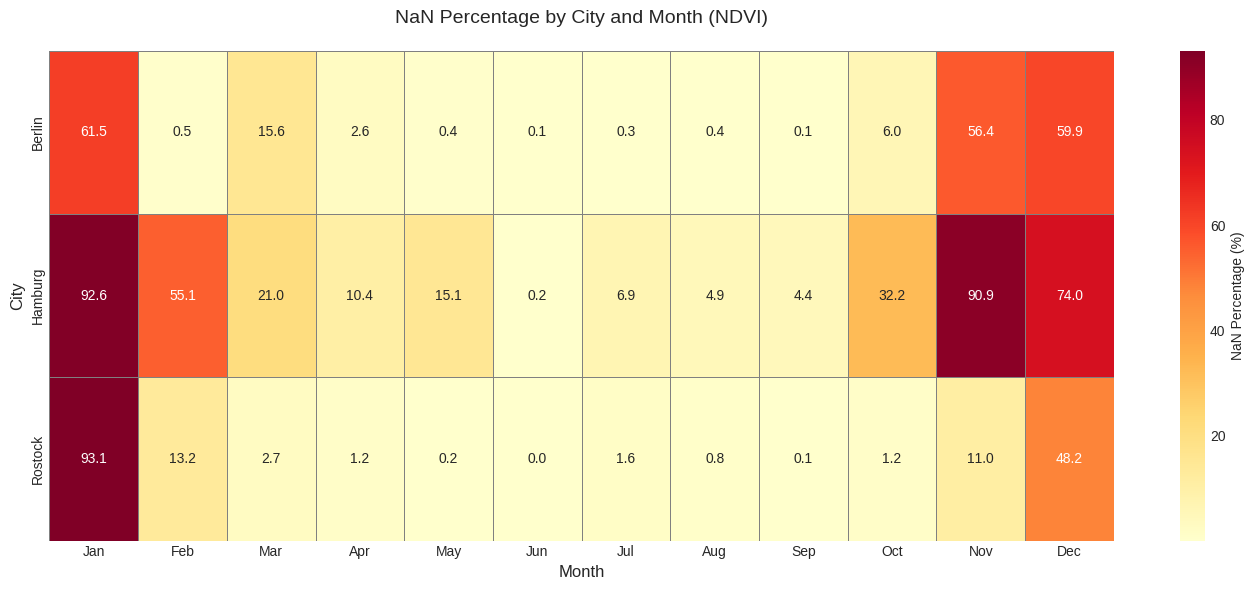

In [15]:
print_section_header("VISUALIZATION: NaN HEATMAP")

# Create heatmap: City × Month → NaN percentage
fig, ax = plt.subplots(figsize=(14, 6))

# Prepare data for heatmap
heatmap_data = nan_pivot.T  # Transpose to get cities as rows

# Create heatmap
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt='.1f',
    cmap='YlOrRd',
    cbar_kws={'label': 'NaN Percentage (%)'},
    linewidths=0.5,
    linecolor='gray',
    ax=ax
)

# Formatting
ax.set_title('NaN Percentage by City and Month (NDVI)', fontsize=14, pad=20)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('City', fontsize=12)
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.tight_layout()

# Save
heatmap_path = PLOTS_DIR / 'nan_heatmap_city_month.png'
plt.savefig(heatmap_path, dpi=300, bbox_inches='tight')
print(f"\n✅ Heatmap saved to: {heatmap_path.name}")

plt.show()

---

## 7. POST-FILTER STATISTICS & VALIDATION

### 7.1 Updated Tree Counts

In [16]:
print_section_header("CONSOLIDATED DATASET STATISTICS")

def generate_statistics_table(gdf, variant_name):
    """Generate comprehensive statistics table."""
    print(f"\n{variant_name.upper()}:")
    print("-" * 80)

    # Overall counts
    print(f"Total trees: {len(gdf):,}")

    # By city
    print("\nBy city:")
    city_counts = gdf['city'].value_counts().sort_index()
    for city, count in city_counts.items():
        pct = count / len(gdf) * 100
        print(f"  {city}: {count:,} ({pct:.1f}%)")

    # By species_group (Botanical)
    print("\nBy species group (Botanical):")
    sg_counts = gdf['species_group'].value_counts()
    for sg, count in sg_counts.items():
        pct = count / len(gdf) * 100
        print(f"  {sg}: {count:,} ({pct:.1f}%)")

    # By tree_type (Location)
    print("\nBy tree type (Location):")
    if 'tree_type' in gdf.columns:
        tt_counts = gdf['tree_type'].value_counts()
        for tt, count in tt_counts.items():
            pct = count / len(gdf) * 100
            print(f"  {tt}: {count:,} ({pct:.1f}%)")

    # By genus (top 15)
    print("\nBy genus (top 15):")
    genus_counts = gdf['genus_latin'].value_counts().head(15)
    for genus, count in genus_counts.items():
        pct = count / len(gdf) * 100
        sg = GENUS_TYPE_MAPPING.get(genus, 'unknown')
        print(f"  {genus:15s} ({sg:10s}): {count:6,} ({pct:5.1f}%)")

    # CHM height statistics
    print("\nCHM height statistics (m):")
    height = gdf['height_m']
    print(f"  Mean: {height.mean():.2f}")
    print(f"  Median: {height.median():.2f}")
    print(f"  Std: {height.std():.2f}")
    print(f"  Min: {height.min():.2f}")
    print(f"  Max: {height.max():.2f}")

# Generate statistics for both datasets
generate_statistics_table(trees_no_edge, 'no_edge')
generate_statistics_table(trees_edge_20m, 'edge_20m')


CONSOLIDATED DATASET STATISTICS

NO_EDGE:
--------------------------------------------------------------------------------
Total trees: 747,960

By city:
  Berlin: 592,568 (79.2%)
  Hamburg: 112,220 (15.0%)
  Rostock: 43,172 (5.8%)

By species group (Botanical):
  deciduous: 747,960 (100.0%)

By tree type (Location):
  Straßenbaum: 316,968 (42.4%)
  Anlagenbaum: 275,600 (36.8%)

By genus (top 15):
  TILIA           (deciduous ): 196,373 ( 26.3%)
  ACER            (deciduous ): 165,372 ( 22.1%)
  QUERCUS         (deciduous ): 106,667 ( 14.3%)
  BETULA          (deciduous ): 32,037 (  4.3%)
  PLATANUS        (deciduous ): 29,408 (  3.9%)
  AESCULUS        (deciduous ): 29,228 (  3.9%)
  ROBINIA         (deciduous ): 26,068 (  3.5%)
  CARPINUS        (deciduous ): 25,605 (  3.4%)
  FRAXINUS        (deciduous ): 22,667 (  3.0%)
  POPULUS         (deciduous ): 21,972 (  2.9%)
  PRUNUS          (deciduous ): 18,456 (  2.5%)
  FAGUS           (deciduous ): 13,241 (  1.8%)
  ULMUS           (

### 8.2 No-Edge vs. Edge-Filtered Comparison

In [17]:
print_section_header("COMPARISON: NO-EDGE vs. EDGE-FILTERED")

# Create comparison DataFrame
comparison_data = []

for city in PROCESSING_PARAMS['cities']:
    no_edge_count = (trees_no_edge['city'] == city).sum()
    edge_count = (trees_edge_20m['city'] == city).sum()
    removed = no_edge_count - edge_count
    removal_rate = (removed / no_edge_count * 100) if no_edge_count > 0 else 0

    comparison_data.append({
        'City': city,
        'No-Edge': no_edge_count,
        'Edge-20m': edge_count,
        'Removed': removed,
        'Removal Rate (%)': removal_rate
    })

# Add totals
comparison_data.append({
    'City': 'TOTAL',
    'No-Edge': len(trees_no_edge),
    'Edge-20m': len(trees_edge_20m),
    'Removed': len(trees_no_edge) - len(trees_edge_20m),
    'Removal Rate (%)': (len(trees_no_edge) - len(trees_edge_20m)) / len(trees_no_edge) * 100
})

comparison_df = pd.DataFrame(comparison_data)

print("\nEdge filter impact by city:")
print("-" * 80)
print(comparison_df.to_string(index=False))

print("\n" + "=" * 80)
print("INTERPRETATION:")
print("The 20m edge filter removes trees within 20m of tile boundaries to mitigate")
print("potential edge effects in remote sensing data (e.g., geometric distortions,")
print("atmospheric corrections, overlapping scenes).")
print("=" * 80)


COMPARISON: NO-EDGE vs. EDGE-FILTERED

Edge filter impact by city:
--------------------------------------------------------------------------------
   City  No-Edge  Edge-20m  Removed  Removal Rate (%)
 Berlin   592568    230448   362120         61.110286
Hamburg   112220     64701    47519         42.344502
Rostock    43172     17532    25640         59.390346
  TOTAL   747960    312681   435279         58.195492

INTERPRETATION:
The 20m edge filter removes trees within 20m of tile boundaries to mitigate
potential edge effects in remote sensing data (e.g., geometric distortions,
atmospheric corrections, overlapping scenes).


### 8.3 CHM Height Distribution by Genus


VISUALIZATION: CHM HEIGHT BY GENUS

✅ Box plot saved to: chm_height_by_genus_boxplot.png


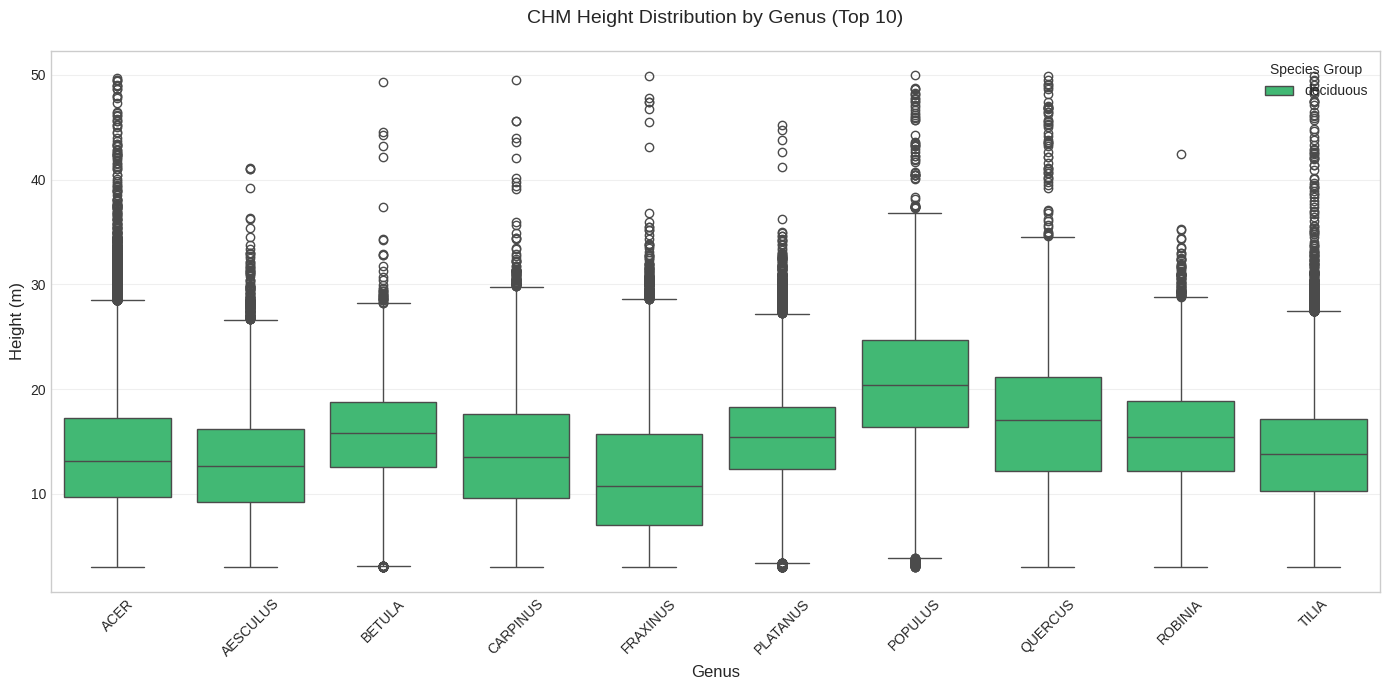

In [18]:
print_section_header("VISUALIZATION: CHM HEIGHT BY GENUS")

# Select top 10 genera by abundance
top_genera = trees_no_edge['genus_latin'].value_counts().head(10).index.tolist()
subset = trees_no_edge[trees_no_edge['genus_latin'].isin(top_genera)].copy()

# Create box plot
fig, ax = plt.subplots(figsize=(14, 7))

# Prepare data
subset_sorted = subset.sort_values('genus_latin')

# Box plot
sns.boxplot(
    data=subset_sorted,
    x='genus_latin',
    y='height_m',
    hue='species_group',
    palette={'deciduous': '#2ecc71', 'conifer': '#3498db'},
    ax=ax
)

# Formatting
ax.set_title('CHM Height Distribution by Genus (Top 10)', fontsize=14, pad=20)
ax.set_xlabel('Genus', fontsize=12)
ax.set_ylabel('Height (m)', fontsize=12)
ax.tick_params(axis='x', rotation=45)
ax.legend(title='Species Group', loc='upper right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()

# Save
boxplot_path = PLOTS_DIR / 'chm_height_by_genus_boxplot.png'
plt.savefig(boxplot_path, dpi=300, bbox_inches='tight')
print(f"\n✅ Box plot saved to: {boxplot_path.name}")

plt.show()

### 8.4 Final Data Validation

In [19]:
print_section_header("FINAL DATA VALIDATION")

def validate_final_dataset(gdf, variant_name):
    """Perform comprehensive validation checks."""
    print(f"\n{variant_name.upper()}:")
    print("-" * 40)

    issues = []

    # Check 1: Required columns
    required_cols = ['tree_id', 'city', 'genus_latin', 'species_latin', 'tree_type', 'species_group', 'geometry']
    missing_cols = [col for col in required_cols if col not in gdf.columns]
    if missing_cols:
        issues.append(f"Missing columns: {missing_cols}")
    else:
        print("  ✅ All required columns present")

    # Check 2: CRS consistency
    if gdf.crs is None:
        issues.append("CRS not defined")
    else:
        print(f"  ✅ CRS: {gdf.crs}")

    # Check 3: Geometry validity
    invalid_geom = ~gdf.geometry.is_valid
    if invalid_geom.any():
        issues.append(f"Invalid geometries: {invalid_geom.sum()}")
    else:
        print(f"  ✅ All geometries valid")

    # Check 4: Feature completeness
    chm_cols = [c for c in gdf.columns if c.startswith('CHM') or c == 'height_m']

    # Recalculate S2 cols
    s2_cols = []
    for col in gdf.columns:
        for band in PROCESSING_PARAMS['sentinel2_bands']:
            if col.startswith(f"{band}_"):
                s2_cols.append(col)
                break

    if len(chm_cols) != 4:
        issues.append(f"CHM features: {len(chm_cols)} (expected 4)")
    else:
        print(f"  ✅ CHM features: {len(chm_cols)}")

    if len(s2_cols) != 276:
        issues.append(f"Sentinel-2 features: {len(s2_cols)} (expected 276)")
    else:
        print(f"  ✅ Sentinel-2 features: {len(s2_cols)}")

    # Check 5: species_group mapping
    unmapped = gdf['species_group'].isna().sum()
    if unmapped > 0:
        issues.append(f"Unmapped species_group: {unmapped} trees")
    else:
        print(f"  ✅ All trees have species_group assigned")

    # Summary
    if issues:
        print(f"\n  ⚠️  {len(issues)} validation issue(s) detected:")
        for issue in issues:
            print(f"    - {issue}")
        return False
    else:
        print(f"\n  ✅ Dataset passed all validation checks")
        return True

# Validate both datasets
valid_no_edge = validate_final_dataset(trees_no_edge, 'no_edge')
valid_edge_20m = validate_final_dataset(trees_edge_20m, 'edge_20m')

print("\n" + "=" * 80)
if valid_no_edge and valid_edge_20m:
    print("✅ VALIDATION PASSED: Both datasets ready for export")
else:
    print("❌ VALIDATION FAILED: Review issues above before export")
print("=" * 80)


FINAL DATA VALIDATION

NO_EDGE:
----------------------------------------
  ✅ All required columns present
  ✅ CRS: EPSG:25832
  ✅ All geometries valid
  ✅ CHM features: 4
  ✅ Sentinel-2 features: 276
  ✅ All trees have species_group assigned

  ✅ Dataset passed all validation checks

EDGE_20M:
----------------------------------------
  ✅ All required columns present
  ✅ CRS: EPSG:25832
  ✅ All geometries valid
  ✅ CHM features: 4
  ✅ Sentinel-2 features: 276
  ✅ All trees have species_group assigned

  ✅ Dataset passed all validation checks

✅ VALIDATION PASSED: Both datasets ready for export


---

## 9. EXPORT RESULTS

### 9.1 Export Cleaned Datasets

In [20]:
print_section_header("EXPORTING CLEANED DATASETS")

# Remove temporary columns before export
# 'dataset_variant' is internal; 'species_group' is redundant as we filtered to only deciduous
cols_to_drop = ['dataset_variant', 'species_group']

export_no_edge = trees_no_edge.drop(columns=cols_to_drop, errors='ignore')
export_edge_20m = trees_edge_20m.drop(columns=cols_to_drop, errors='ignore')

# Export paths
output_no_edge = OUTPUT_DATA_DIR / 'trees_qc_no_edge.gpkg'
output_edge_20m = OUTPUT_DATA_DIR / 'trees_qc_edge_20m.gpkg'

# Export to GeoPackage
print("\nExporting GeoPackages...")
export_no_edge.to_file(output_no_edge, driver='GPKG')
print(f"  ✅ No-edge dataset: {len(export_no_edge):,} trees → {output_no_edge.name}")

export_edge_20m.to_file(output_edge_20m, driver='GPKG')
print(f"  ✅ Edge-20m dataset: {len(export_edge_20m):,} trees → {output_edge_20m.name}")

print("\n✅ All datasets exported successfully")


EXPORTING CLEANED DATASETS

Exporting GeoPackages...
  ✅ No-edge dataset: 747,960 trees → trees_qc_no_edge.gpkg
  ✅ Edge-20m dataset: 312,681 trees → trees_qc_edge_20m.gpkg

✅ All datasets exported successfully


### 9.2 Export Metadata & Reports

In [21]:
print_section_header("EXPORTING METADATA & REPORTS")

# 1. QC Report (JSON)
qc_report = {
    'processing_date': pd.Timestamp.now().isoformat(),
    'notebook': '02_data_quality_control',
    'final_counts': {
        'no_edge': {
            'total': len(trees_no_edge),
            'by_city': trees_no_edge['city'].value_counts().to_dict(),
            'by_tree_type': trees_no_edge['tree_type'].value_counts().to_dict(),
            'by_genus': trees_no_edge['genus_latin'].value_counts().head(20).to_dict()
        },
        'edge_20m': {
            'total': len(trees_edge_20m),
            'by_city': trees_edge_20m['city'].value_counts().to_dict(),
            'by_tree_type': trees_edge_20m['tree_type'].value_counts().to_dict(),
            'by_genus': trees_edge_20m['genus_latin'].value_counts().head(20).to_dict()
        }
    }
}

report_path = METADATA_DIR / 'qc_report.json'
with open(report_path, 'w') as f:
    json.dump(qc_report, f, indent=2)

print(f"  ✅ QC report: {report_path.name}")

# 2. Genus mapping already exported in Section 5.2
print(f"  ✅ Genus type mapping: genus_type_mapping.json (already exported)")

# 3. NaN statistics already exported in Section 6.1
print(f"  ✅ NaN statistics: nan_statistics_by_month_city.csv (already exported)")

print("\n✅ All metadata exported successfully")


EXPORTING METADATA & REPORTS
  ✅ QC report: qc_report.json
  ✅ Genus type mapping: genus_type_mapping.json (already exported)
  ✅ NaN statistics: nan_statistics_by_month_city.csv (already exported)

✅ All metadata exported successfully


---

## 10. SUMMARY & NEXT STEPS

### 10.1 Processing Summary

In [22]:
print("\n" + "=" * 80)
print("NOTEBOOK COMPLETE - DATA QUALITY CONTROL SUMMARY")
print("=" * 80)

summary_text = f"""
✅ DATA LOADING & CONSOLIDATION
  • Loaded 6 city-specific files (3 cities × 2 variants)
  • Consolidated into 2 unified datasets

✅ GENUS CLASSIFICATION & FILTERING
  • Identified {len(all_genera)} unique genera
  • Filtered dataset to retain only deciduous trees (removed conifers)
  • Preserved existing 'tree_type' (location info)

✅ NaN ANALYSIS (DESCRIPTIVE)
  • Analyzed temporal data gaps by city and month
  • Identified systematic missing data patterns
  • Generated heatmap visualization

✅ FINAL DATASETS
  • No-edge: {len(trees_no_edge):,} trees (all cities combined)
  • Edge-20m: {len(trees_edge_20m):,} trees (all cities combined)
  • Features: 280 per tree (4 CHM + 276 Sentinel-2)
  • Metadata: tree_id, city, genus_latin, species_latin, tree_type

OUTPUT FILES:
  📁 {OUTPUT_DATA_DIR.name}/
    ├── trees_qc_no_edge.gpkg
    └── trees_qc_edge_20m.gpkg

  📁 {METADATA_DIR.name}/
    ├── genus_type_mapping.json
    ├── nan_statistics_by_month_city.csv
    └── qc_report.json

  📁 {PLOTS_DIR.name}/
    ├── nan_heatmap_city_month.png
    └── chm_height_by_genus_boxplot.png

NEXT STEPS:
  → Proceed to Notebook 03: Feature Reduction & Statistical Filtering
    • Apply vegetation plausibility filter (NDVI)
    • Temporal feature importance analysis
    • Spectral band selection
    • Statistical outlier detection
"""

print(summary_text)
print("=" * 80)


NOTEBOOK COMPLETE - DATA QUALITY CONTROL SUMMARY

✅ DATA LOADING & CONSOLIDATION
  • Loaded 6 city-specific files (3 cities × 2 variants)
  • Consolidated into 2 unified datasets

✅ GENUS CLASSIFICATION & FILTERING
  • Identified 20 unique genera
  • Filtered dataset to retain only deciduous trees (removed conifers)
  • Preserved existing 'tree_type' (location info)

✅ NaN ANALYSIS (DESCRIPTIVE)
  • Analyzed temporal data gaps by city and month
  • Identified systematic missing data patterns
  • Generated heatmap visualization

✅ FINAL DATASETS
  • No-edge: 747,960 trees (all cities combined)
  • Edge-20m: 312,681 trees (all cities combined)
  • Features: 280 per tree (4 CHM + 276 Sentinel-2)
  • Metadata: tree_id, city, genus_latin, species_latin, tree_type

OUTPUT FILES:
  📁 data/
    ├── trees_qc_no_edge.gpkg
    └── trees_qc_edge_20m.gpkg

  📁 metadata/
    ├── genus_type_mapping.json
    ├── nan_statistics_by_month_city.csv
    └── qc_report.json

  📁 plots/
    ├── nan_heatmap_c

---

**Notebook End**

Exported: 2025-01-11

Author: Silas Pignotti